## Test against error

In [1]:
from quality_utils import *
import open3d as o3d
import numpy as np
import copy
import matplotlib.pyplot as plt
from tqdm import tqdm

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
target = loadPCD("data/chair_target.ply")
target.paint_uniform_color([1, 0.706, 0])
source = loadPCD("data/chair_source.ply")
source.paint_uniform_color([0, 0.651, 0.929])
# o3d.visualization.draw_geometries([target, source])

PointCloud with 37744 points.

In [3]:
voxel_size = 0.05

In [4]:
source_down, source_fpfh = preprocess_point_cloud(source, voxel_size)
target_down, target_fpfh = preprocess_point_cloud(target, voxel_size)

# Coarse registration
global_registration_result = execute_global_registration(source_down, target_down, source_fpfh, target_fpfh, voxel_size)

# Refine registration
refine_registration_result = refine_registration(source, target, source_fpfh, target_fpfh, voxel_size, global_registration_result.transformation)

:: Downsample with a voxel size 0.050.
:: Estimate normal with search radius 0.100.
:: Compute FPFH feature with search radius 0.250.
:: Downsample with a voxel size 0.050.
:: Estimate normal with search radius 0.100.
:: Compute FPFH feature with search radius 0.250.
:: RANSAC registration on downsampled point clouds.
   Since the downsampling voxel size is 0.050,
   we use a liberal distance threshold 0.075.
:: Point-to-plane ICP registration is applied on original point
   clouds to refine the alignment. This time we use a strict
   distance threshold 0.020.


In [5]:
# Find origins
source_origin = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.03, origin=[0, 0, 0])
target_origin = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.06, origin=[0, 0, 0])

# Transform the source origin
source_origin.transform(np.linalg.inv(refine_registration_result.transformation))

# Visualize the point clouds and their origins
source_copy = copy.deepcopy(source) 
source_copy.transform(refine_registration_result.transformation)

o3d.visualization.draw_geometries([target, source_copy, source_origin, target_origin])

Alignment Quality:  0.823361430280194


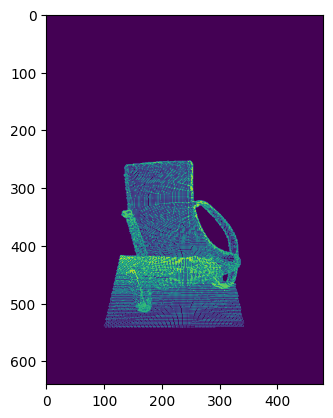

In [6]:
T = refine_registration_result.transformation
I11, I12, I21, I22 = get_projections(target, np.identity(4), source_copy, np.linalg.inv(T), save=True)

p = get_p(I11, I12, I21, I22, sigma=0.01)
print("Alignment Quality: ", p)

In [7]:
error = np.linspace(-1,1,51)
print("Error: ", error)

Error:  [-1.   -0.96 -0.92 -0.88 -0.84 -0.8  -0.76 -0.72 -0.68 -0.64 -0.6  -0.56
 -0.52 -0.48 -0.44 -0.4  -0.36 -0.32 -0.28 -0.24 -0.2  -0.16 -0.12 -0.08
 -0.04  0.    0.04  0.08  0.12  0.16  0.2   0.24  0.28  0.32  0.36  0.4
  0.44  0.48  0.52  0.56  0.6   0.64  0.68  0.72  0.76  0.8   0.84  0.88
  0.92  0.96  1.  ]


In [8]:
T = refine_registration_result.transformation

100%|██████████| 51/51 [02:59<00:00,  3.52s/it]


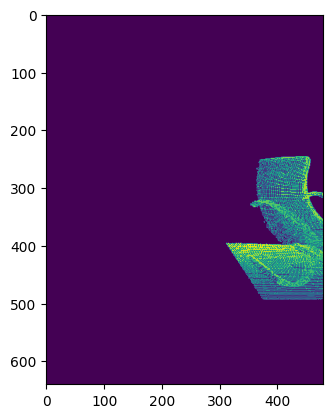

In [9]:
# Adding Error to X
quality_error_x = []

for e in tqdm(error):
    source_copy = copy.deepcopy(source) 
    source_copy.transform(refine_registration_result.transformation)

    source_copy.translate([e, 0, 0])
    I11, I12, I21, I22 = get_projections(target, np.identity(4), source_copy, np.linalg.inv(T))
    p = get_p(I11, I12, I21, I22, sigma=0.01)
    # print("Alignment Quality: ", p)
    quality_error_x.append(p)



100%|██████████| 51/51 [03:00<00:00,  3.54s/it]


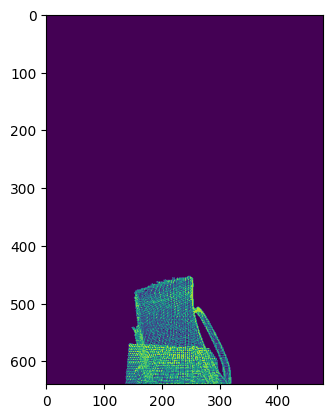

In [10]:
quality_error_y = []

for e in tqdm(error):
    source_copy = copy.deepcopy(source) 
    source_copy.transform(refine_registration_result.transformation)

    source_copy.translate([0, e, 0])
    I11, I12, I21, I22 = get_projections(target, np.identity(4), source_copy, np.linalg.inv(T))
    p = get_p(I11, I12, I21, I22, sigma=0.01)
    # print("Alignment Quality: ", p)
    quality_error_y.append(p)

100%|██████████| 51/51 [02:59<00:00,  3.52s/it]


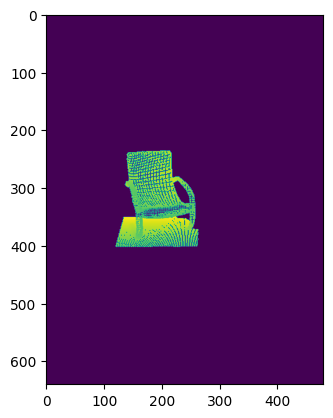

In [11]:
quality_error_z = []

for e in tqdm(error):
    source_copy = copy.deepcopy(source) 
    source_copy.transform(refine_registration_result.transformation)

    source_copy.translate([0, 0, e])
    I11, I12, I21, I22 = get_projections(target, np.identity(4), source_copy, np.linalg.inv(T))
    p = get_p(I11, I12, I21, I22, sigma=0.01)
    # print("Alignment Quality: ", p)
    quality_error_z.append(p)

100%|██████████| 51/51 [02:58<00:00,  3.51s/it]


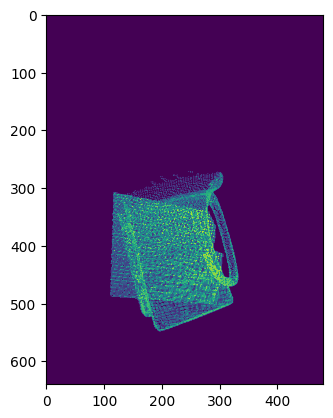

In [12]:
quality_error_roll = []

for e in tqdm(error):
    source_copy = copy.deepcopy(source) 
    source_copy.transform(refine_registration_result.transformation)

    source_copy.rotate(o3d.geometry.get_rotation_matrix_from_axis_angle([e, 0, 0]))
    I11, I12, I21, I22 = get_projections(target, np.identity(4), source_copy, np.linalg.inv(T))
    p = get_p(I11, I12, I21, I22, sigma=0.01)
    # print("Alignment Quality: ", p)
    quality_error_roll.append(p)


100%|██████████| 51/51 [02:58<00:00,  3.50s/it]


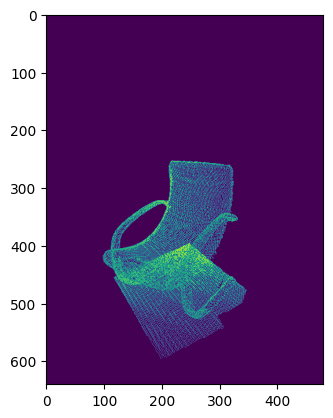

In [13]:
quality_error_pitch = []

for e in tqdm(error):
    source_copy = copy.deepcopy(source) 
    source_copy.transform(refine_registration_result.transformation)

    source_copy.rotate(o3d.geometry.get_rotation_matrix_from_axis_angle([0, e, 0]))
    I11, I12, I21, I22 = get_projections(target, np.identity(4), source_copy, np.linalg.inv(T))
    p = get_p(I11, I12, I21, I22, sigma=0.01)
    # print("Alignment Quality: ", p)
    quality_error_pitch.append(p)

100%|██████████| 51/51 [02:59<00:00,  3.52s/it]


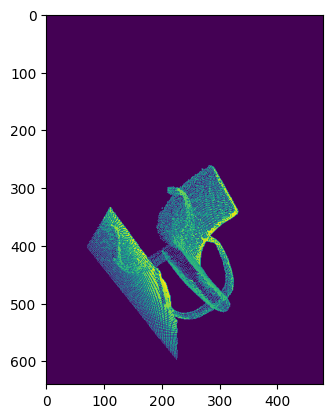

In [14]:
quality_error_yaw = []

for e in tqdm(error):
    source_copy = copy.deepcopy(source) 
    source_copy.transform(refine_registration_result.transformation)

    source_copy.rotate(o3d.geometry.get_rotation_matrix_from_axis_angle([0, 0, e]))
    I11, I12, I21, I22 = get_projections(target, np.identity(4), source_copy, np.linalg.inv(T))
    p = get_p(I11, I12, I21, I22, sigma=0.01)
    # print("Alignment Quality: ", p)
    quality_error_yaw.append(p)

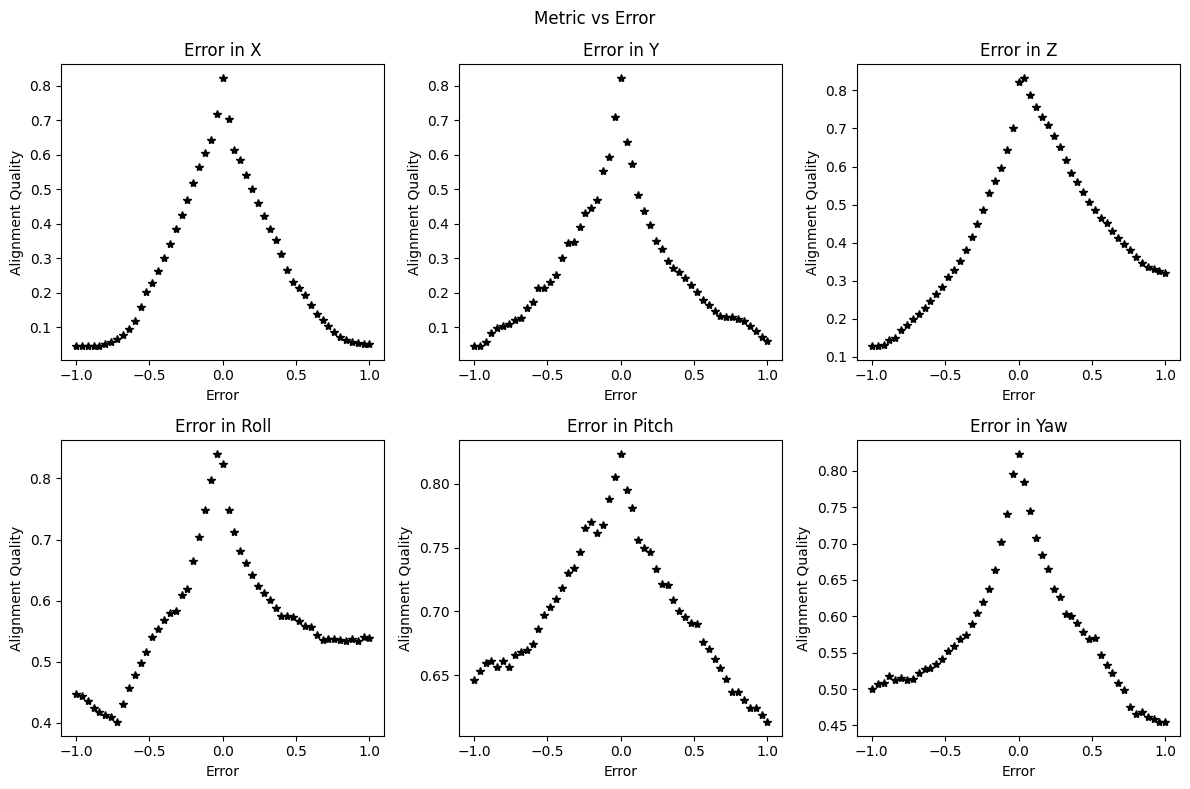

In [15]:
# Create a single plot for all the errors shown in different subplots
fig, axs = plt.subplots(2, 3, figsize=(12, 8))
fig.suptitle('Metric vs Error')

axs[0, 0].plot(error, quality_error_x, 'k*')
axs[0, 0].set_title('Error in X')
# axs[0, 0].set_aspect('equal', adjustable='datalim')
axs[0, 1].plot(error, quality_error_y, 'k*')
axs[0, 1].set_title('Error in Y')
# axs[0, 1].set_aspect('equal', adjustable='datalim')
axs[0, 2].plot(error, quality_error_z, 'k*')
axs[0, 2].set_title('Error in Z')
# axs[0, 2].set_aspect('equal', adjustable='datalim')
axs[1, 0].plot(error, quality_error_roll, 'k*')
axs[1, 0].set_title('Error in Roll')
# axs[1, 0].set_aspect('equal', adjustable='datalim')
axs[1, 1].plot(error, quality_error_pitch, 'k*')
axs[1, 1].set_title('Error in Pitch')
# axs[1, 1].set_aspect('equal', adjustable='datalim')
axs[1, 2].plot(error, quality_error_yaw, 'k*')
axs[1, 2].set_title('Error in Yaw')
# axs[1, 2].set_aspect('equal', adjustable='datalim')

for ax in axs.flat:
    ax.set(xlabel='Error', ylabel='Alignment Quality')

fig.tight_layout()